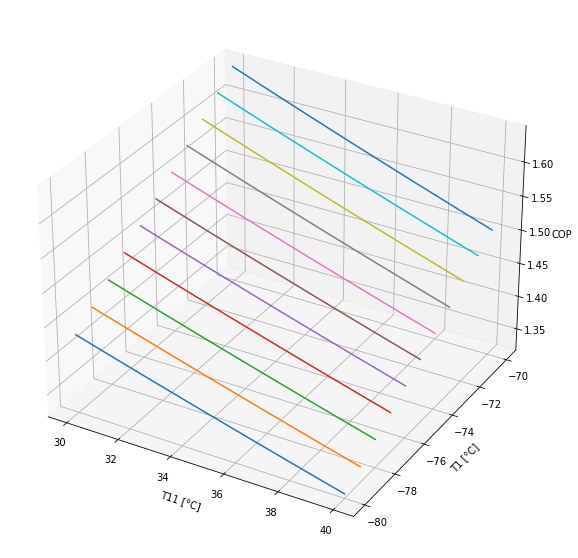

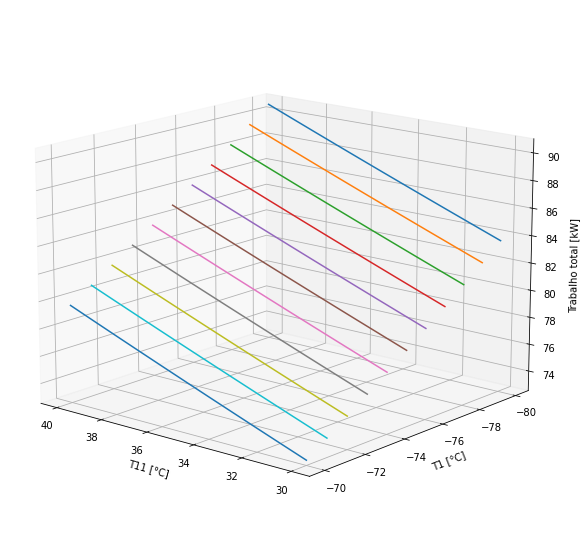

In [4]:
#Bibliotecas
from CoolProp.CoolProp import PropsSI as CP
import math
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.axes3d import get_test_data
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

#Listas
T1_lista = []
T11_lista = []
Wcomp_total_lista = []
COP_lista = []
cont = []

#Listas de temperaturas de condensação
for i in range (30, 41, 1):
    cont.append(i+273.15)

#Dados do problema
Pfrig = 120 * 1000 #[W]
T3 = -35 + 273.15 #[K]
T5 = -39 + 273.15 #[K]
T7 = -8 + 273.15 #[K]
T9 = -12 + 273.15 #[K]
fluid_high = 'R717'
fluid_medium = 'R744'
fluid_low = 'R41'
n = 1.1
drop_suc = 12000 #[Pa]
drop_desc = 24000 #[Pa]

#Pressão crítica do fluido superior
P_crit_high = CP('PCRIT', fluid_high)

#Ciclo inferior
P3 = CP('P', 'T', T3, 'Q', 0 , fluid_low)
P2 = P3
Pc = P2 + drop_desc
h3 = CP('H', 'T', T3, 'Q', 0, fluid_low)
h4 = h3

#Ciclo intermediário
P5 = CP('P', 'T', T5, 'Q', 1, fluid_medium)
h5 = CP('H', 'T', T5, 'Q', 1, fluid_medium)
hw = h5
Pw = P5 - drop_suc
Tw = CP('T', 'H', hw, 'P', Pw, fluid_medium)
Px = Pw
Tx = Tw + 4 #superaquecimento de 4°C na admissão
vx = 1 / CP('D', 'T', Tx, 'P', Px, fluid_medium)
P7 = CP('P', 'T', T7, 'Q', 0, fluid_medium)
P6 = P7
r2 = P6/P5
Py = P6 + drop_desc
h7 = CP('H', 'T', T7, 'Q', 0, fluid_medium)
h8 = h7

#Ciclo superior
P9 = CP('P', 'T', T9, 'Q', 1, fluid_high)
h9 = CP('H', 'T', T9, 'Q', 1, fluid_high)
he = h9
Pe = P9 - drop_suc
Te = CP('T', 'H', he, 'P', Pe, fluid_high)
Pf = Pe
Tf = Te + 4 #superaquecimento de 4°C na admissão
vf = 1 / CP('D', 'T', Tf, 'P', Pf, fluid_high)

#Loop nos três ciclos - variação das temperaturas de evaporação e condensação
for T1 in range (-80, -69, 1):
    #Ciclo inferior
    T1 = T1 + 273.15
    P1 = CP('P', 'T', T1, 'Q', 1, fluid_low)
    r1 = P2/P1
    h1 = CP('H', 'T', T1, 'Q', 1, fluid_low)
    ha = h1
    Pa = P1 - drop_suc
    Ta = CP('T', 'H', ha, 'P', Pa, fluid_low)
    Pb = Pa
    Tb = Ta + 4 #superaquecimento de 4°C na admissão
    vb = 1 / CP('D', 'T', Tb, 'P', Pb, fluid_low)
    m_flow_low = Pfrig / (h1 - h4)
    vc = (Pb * vb ** n / Pc)**(1 / n)
    hc = CP('H', 'P', Pc, 'D', 1 / vc, fluid_low)
    h2 = hc
    #Trabalho específico do compressor do ciclo inferior
    w_low = n / (n-1) * Pb * vb * ((Pc/Pb)**((n-1)/n) - 1)
    #Trabalho do compressor do ciclo inferior
    Wcomp_low = m_flow_low * w_low
    #Calor trocado no trocador entre o ciclo inferior e o intermediário
    Qcond_low =  m_flow_low * (h2 - h3)
    #Ciclo intermediário
    Qevap_medium = Qcond_low
    m_flow_medium = Qevap_medium / (h5 - h8)
    vy = (Px * vx ** n / Py)**(1 / n)
    hy = CP('H', 'P', Py, 'D', 1 / vy, fluid_medium)
    h6 = hy
    #Trabalho específico do compressor do ciclo intermediário
    w_medium = n / (n-1) * Px * vx * ((Py/Px)**((n-1)/n) - 1)
    #Trabalho no compressor do ciclo intermediário
    Wcomp_medium = m_flow_medium * w_medium
    #Calor trocado no trocador entre o ciclo intermediário e o superior
    Qcond_medium = m_flow_medium * (h6 - h7)
    for T11 in cont:
        #Ciclo superior
        P11 = CP('P', 'T', T11, 'Q', 0, fluid_high)
        P10 = P11
        r3 = P10/P9
        Pg = P10 + drop_desc
        h11 = CP('H', 'T', T11, 'Q', 0, fluid_high)
        h12 = h11
        Qevap_high = Qcond_medium
        m_flow_high = Qevap_high / (h9 - h12)
        vg = (Pf * vf ** n / Pg)**(1 / n)
        #Verificação da pressão crítica
        if P_crit_high > P10:
            T1_lista.append(T1 - 273.15)
            T11_lista.append(T11 - 273.15)
            #Trabalho específico do compressor do ciclo superior
            w_high = n / (n-1) * Pf * vf * ((Pg/Pf)**((n-1)/n) - 1)
            #Trabalho no compressor do ciclo superior
            Wcomp_high = m_flow_high * w_high
            #Trabalho total do ciclo
            Wcomp_total = Wcomp_low + Wcomp_medium + Wcomp_high
            Wcomp_total_lista.append(Wcomp_total / 1000)
            #COP
            COP = Pfrig / Wcomp_total
            COP_lista.append(COP)
        else:
            print ('A pressão P10 = {:0.2f} kPa (T1 = {:0.2f}°C, T11 = {:0.2f}°C) é maior do que a ' 
               'pressão crítica do {} e, por isso, o ponto não foi incluído no gráfico'
                   .format(P10/1000,T1-273.15,T11-273.15,fluid_high))

if len(T1_lista) !=0:
    fig = plt.figure(figsize=[10, 10])
    ax = fig.add_subplot(1, 1, 1, projection ='3d')
    for i in range (0, len(COP_lista), len(cont)):
        x1line = []
        y1line = []
        z1line = []
        for j in range (i, i + len(cont), 1):
            y1line.append(T1_lista[i])
            x1line.append(T11_lista[j])
            z1line.append (COP_lista[j])
        ax.set_xlabel('T11 [°C]', size = 10)
        ax.set_ylabel('T1 [°C]', size = 10)
        ax.set_zlabel('COP', size = 10)
        ax.plot3D(x1line, y1line, z1line) 
    plt.show()
else:
    print ('Todos os pontos são inválidos')
    
if len(T1_lista) !=0:
    fig = plt.figure(figsize=[10, 10])
    ax = fig.add_subplot(1, 1, 1, projection ='3d')
    for i in range (0, len(Wcomp_total_lista), len(cont)):
        x1line = []
        y1line = []
        z1line = []
        for j in range (i, i + len(cont), 1):
            y1line.append(T1_lista[i])
            x1line.append(T11_lista[j])
            z1line.append (Wcomp_total_lista[j])
        ax.set_xlabel('T11 [°C]', size = 10)
        ax.set_ylabel('T1 [°C]', size = 10)
        ax.set_zlabel('Trabalho total [kW]', size = 10)
        ax.plot3D(x1line, y1line, z1line) 
        ax.view_init(15, 130)
    plt.show()
else:
    print ('Todos os pontos são inválidos')
